In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from train_gtex import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches
import seaborn as sns
from src.train_utils import forward, encode, decode
from src.ct_signature_utils import *
from src.distributions import *
from src.eval_utils import *
from tqdm import tqdm
import torch
import torch.nn as nn
from src.metagene_decoders import get_decoder
from src.hnn_utils import MLP
import types
import itertools
from sklearn.linear_model import LinearRegression, Ridge
sns.set_style("whitegrid")

In [11]:
MODEL_PATH = '/local/scratch-2/rv340/multitissue/models/normalised_model_default.pth'
RESULTS_DIR = '/home/rv340/HYFA/results'
GTEX_FILE = '/local/scratch/rv340/gtex/GTEX_data.csv'
GTEX_v9_FILE = '/local/scratch-2/rv340/GTEx/v9/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad'
METADATA_FILE = '/local/scratch/rv340/gtex/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt'

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', dest='config', default='configs/default.yaml', type=str)  # '_deconvolution'
args, unknown = parser.parse_known_args()

# Initialise wandb
wandb.init(project='multitissue_imputation', config=args.config, mode='disabled')
config = wandb.config
config.update({'gene_selection_strategy': 'highly variable v9', 'n_top_genes': 3000},  allow_val_change=True)
print(config)

{'gpu': 0, 'sweep': False, 'lr': 0.00045568167228053424, 'batch_size': 63, 'epochs': 200, 'patience': 30, 'dropout': 0.17385777664292695, 'bn': True, 'use_demographic_information': True, 'update_edge_attr': False, 'n_graph_layers': 2, 'n_hidden_layers': 1, 'n_hidden_layers_pred': 2, 'n_hidden_layers_prior_var': 0, 'meta_G': 50, 'd_patient': 71, 'd_gene': 48, 'd_edge_attr': 98, 'd_tissue': 120, 'd_edge': 28, 'n_heads': 28, 'beta': 0, 'n_top_genes': 3000, 'attention_strategy': 'patient', 'metagenes_encoder': 'plain', 'loss_type': 'normal', 'layer': 'gat', 'activation': 'swish', 'norm': 'batch', 'gene_selection_strategy': 'highly variable v9'}


In [6]:
# Use certain GPU
device = torch.device("cuda:{}".format(config.gpu) if torch.cuda.is_available() else "cpu")

# Load data
adata_v8 = GTEx_v8_normalised_adata(file=GTEX_FILE)
adata_v9 = GTEx_v9_adata(file = GTEX_v9_FILE)
# adata_v8, adata_v9 = select_overlapping_genes(adata_v8, adata_v9)

# Compute signatures
ct_key = 'Broad cell type'
ct_adata_v9 = GTEx_v9_signatures(adata_v8, adata_v9, ct_key=ct_key)

# Discard underrepresented cell types
ct_threshold = 10
selected_ct = {k: v for k, v in Counter(ct_adata_v9.obs[ct_key].values).items() if v >= ct_threshold}
adata_v9 = select_obs(adata_v9, {ct_key: selected_ct.keys()})
ct_adata_v9 = select_obs(ct_adata_v9, {ct_key: selected_ct.keys()})

# Store tissue/cell-type dicts
tissue_dict_v9_inv = {v: k for k, v in ct_adata_v9.uns['Tissue_dict'].items()}
ct_dict_inv = {v: k for k, v in ct_adata_v9.uns['ct_dict'].items()}

# Select genes
_, adata_v9 = select_genes(adata_v8=None, adata_v9=adata_v9,
                                  strategy=config.gene_selection_strategy,
                                  n_top_genes=config.n_top_genes)

# Split train/val/test
donors = adata_v8.obs['Participant ID'].values
train_donors, test_donors = split_patient_train_test(donors, train_rate=0.8)
train_donors, val_donors = split_patient_train_test(train_donors, train_rate=0.75)
train_mask = np.isin(donors, train_donors)
test_mask = np.isin(donors, test_donors)
val_mask = np.isin(donors, val_donors)

# Prepare datasets and loaders
collate_fn = Data.from_datalist
train_dataset = HypergraphDataset(adata_v8[train_mask], static=False)
val_dataset = HypergraphDataset(adata_v8[val_mask], static=True, disjoint=True)
test_dataset = HypergraphDataset(adata_v8[test_mask], static=True, disjoint=True)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
Trying to set attribute `._uns` of view, copying.


#### Train model on v8 with overlapping genes

In [12]:
config.update({'G': adata_v8.shape[-1]}, allow_val_change=True)

# Select dynamic/static node types
config.static_node_types = {'Tissue': (len(adata_v8.obs['Tissue_idx'].unique()), config.d_tissue),
                            'metagenes': (config.meta_G, config.d_gene)}
config.dynamic_node_types = {'Participant ID': (len(adata_v8.obs['Participant ID'].unique()), config.d_patient)}

# Model
model = HypergraphNeuralNet(config).to(device)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

#### Fine-tune model on GTEx-v9 signatures

In [15]:
use_observed_library=True

In [16]:
# Prepare adata
ct_adata_v9 = GTEx_v9_signatures(adata_v8, adata_v9, ct_key=ct_key)
ct_adata_v9.layers['x'] = ct_adata_v9.layers['x'] # / ct_adata_v9.obs['n_cells'][..., None]
# ct_adata_v9.obs['n_cells'] = 1
# ct_adata_v9.obs['n_cells_misc'] = 1
# TODO: Fix to proper age for overlapping individuals
donor_age = np.zeros(ct_adata_v9.obs['Age'].shape[-1]) + 0.5
donor_sex = ct_adata_v9.obs['Sex'].map(adata_v8.uns['Sex_dict'])
ct_adata_v9.obsm['Participant ID_feat'] = np.stack((donor_age, donor_sex), axis=-1)

# Datasets
train_mixed_dataset = HypergraphDataset(adata_v8[train_mask], ct_adata_v9, static=False)
val_mixed_dataset = HypergraphDataset(adata_v8[val_mask], ct_adata_v9, static=True)
train_mixed_loader = DataLoader(train_mixed_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)
val_mixed_loader = DataLoader(val_mixed_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


In [17]:
config.update({'loss_type': 'normal'}, allow_val_change=True)
model = HypergraphNeuralNet(config).to(device)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [19]:
# Modify model for transfer learning

# Freeze model's parameters
for param in model.parameters():
    param.requires_grad = False

# Include cell-type representations
d_ct = config.d_tissue # 16
model.params['Cell type'] = nn.Parameter(nn.init.xavier_uniform_(torch.zeros((len(ct_adata_v9.uns['ct_dict']), d_ct))))
# assert model.params['Cell type'].requires_grad and not model.params['Tissue'].requires_grad

# Modify predict MLP to include cell-type representations
in_dim_old = list(model.prediction_mlp.modules())[0][0].in_features
in_dim_new = in_dim_old + d_ct
model.prediction_mlp = MLP(in_dim=in_dim_new,
                           # h_dim=32,
                           out_dim=config.d_edge_attr,
                           # n_layers=1,
                           dropout=config.dropout)

# Modify predict method to incorporate target cell-type representations
model.predict = types.MethodType(ct_predict_v2, model)

# Modify decoder to compute dropout probabilities
config.update({'loss_type': 'zero_inflated_negative_binomial'}, allow_val_change=True)
# model.metagenes_decoder = get_decoder(config.loss_type)(in_dim=config.meta_G * config.d_edge_attr, out_dim=ct_adata_v9.shape[-1])
zi_decoder = get_decoder('zero_inflated_negative_binomial')(in_dim=config.meta_G * config.d_edge_attr, out_dim=ct_adata_v9.shape[-1])
# zi_decoder.px_decoder = model.metagenes_decoder.px_decoder
# zi_decoder.px_scale_decoder = model.metagenes_decoder.px_scale_decoder  # Uncomment to re-learn mean
# zi_decoder.px_r_decoder = model.metagenes_decoder.px_r_decoder  # Uncomment to re-learn mean dispersion
model.metagenes_decoder = zi_decoder

# assert model.metagenes_decoder.px_dropout_decoder.parameters().requires_grad and not model.metagenes_decoder.px_decoder.requires_grad

# Move model to device
model.to(device);

In [20]:
config.update({'epochs': 45}, allow_val_change=True)

# Train
train(config,
      model=model,
      loader=train_mixed_loader,
      val_loader=val_mixed_loader,
      device=device,
      use_observed_library=use_observed_library,
      n_cells=0,
      preprocess_fn=None)

Epoch 1/45. loss: 2.785. val_loss: 2.193
Epoch 2/45. loss: 2.756. val_loss: 2.187
Epoch 3/45. loss: 2.738. val_loss: 2.181
Epoch 4/45. loss: 2.717. val_loss: 2.176
Epoch 5/45. loss: 2.694. val_loss: 2.172
Epoch 6/45. loss: 2.669. val_loss: 2.165
Epoch 7/45. loss: 2.634. val_loss: 2.157
Epoch 8/45. loss: 2.602. val_loss: 2.147
Epoch 9/45. loss: 2.569. val_loss: 2.135
Epoch 10/45. loss: 2.533. val_loss: 2.121
Epoch 11/45. loss: 2.491. val_loss: 2.107
Epoch 12/45. loss: 2.458. val_loss: 2.090
Epoch 13/45. loss: 2.425. val_loss: 2.073
Epoch 14/45. loss: 2.397. val_loss: 2.056
Epoch 15/45. loss: 2.367. val_loss: 2.039
Epoch 16/45. loss: 2.337. val_loss: 2.023
Epoch 17/45. loss: 2.309. val_loss: 2.007
Epoch 18/45. loss: 2.284. val_loss: 1.991
Epoch 19/45. loss: 2.264. val_loss: 1.975
Epoch 20/45. loss: 2.247. val_loss: 1.959
Epoch 21/45. loss: 2.223. val_loss: 1.942
Epoch 22/45. loss: 2.209. val_loss: 1.928
Epoch 23/45. loss: 2.195. val_loss: 1.915
Epoch 24/45. loss: 2.182. val_loss: 1.901
E

#### Investigate train/test overlap

In [ ]:
def count_profiles(profiles, tissue_dict_v9_inv, ct_dict_inv):
    n_tissues_v9 = len(tissue_dict_v9_inv)
    n_cts = len(ct_dict_inv)
    counts = np.zeros((n_tissues_v9, n_cts))
    for t, t_idx in enumerate(tissue_dict_v9_inv.keys()):
        for c, c_idx in enumerate(ct_dict_inv.keys()):
            ind_idxs = ((profiles.target['Tissue'] == t_idx) * (profiles.target['Cell type'] == c_idx)).bool()
            individuals = profiles.target['Participant ID'][ind_idxs]
            counts[t, c] = len(individuals.unique())
    return counts

def plot_count_profiles(counts, ax=None, fillstyle='left'):
    if ax is None:
        ax = plt.gca()
    x, y = np.meshgrid(np.arange(counts.shape[1]), np.arange(counts.shape[0]))
    size_exponent = 1.4
    size = (20*counts.flatten())**size_exponent
    normalised_size = (size - size.min()) / (size.max() - size.min())
    cmap = plt.get_cmap('Blues')
    
    # define the bins and normalize
    color = [cmap(s) for s in normalised_size]
    scat = ax.scatter(x=x.flatten(),
                y=y.flatten(),
                s=[200 if s > 0 else 0 for s in counts.flatten()],
                marker=MarkerStyle('o', fillstyle=fillstyle),
                c=color)
    
    # Hide grid lines
    ax.grid(False)
    
    patches = []
    _, idxs = np.unique(normalised_size, return_index=True)
    for index in idxs:
        count = int(counts.flatten()[index])
        if count > 0:
            patch = mpatches.Patch(color=cmap(normalised_size[index]), label=count)
            patches.append(patch)
        
    plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Individuals', frameon=False)
    
    return ax

In [35]:
mask = np.logical_or(val_mask, test_mask) 
unseen_mixed_dataset = HypergraphDataset(adata_v8[mask], ct_adata_v9, static=True)
unseen_mixed_loader = DataLoader(unseen_mixed_dataset, batch_size=len(unseen_mixed_dataset), collate_fn=collate_fn, shuffle=False)
train_profiles = next(iter(train_mixed_loader))
unseen_profiles = next(iter(unseen_mixed_loader))
train_counts = count_profiles(train_profiles, tissue_dict_v9_inv, ct_dict_inv)
unseen_counts = count_profiles(unseen_profiles, tissue_dict_v9_inv, ct_dict_inv)

In [36]:
train_counts, unseen_counts

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0.],
        [0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2.],
        [0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]]),
 array([[1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 2., 2., 0., 2., 0., 2., 0., 0., 0., 2., 0.]]))

Text(0.5, 1.0, 'Number of train and test individuals')

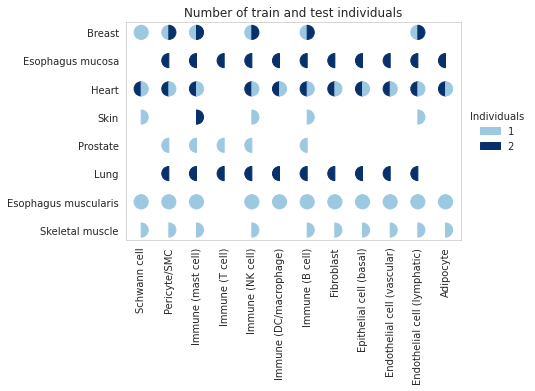

In [37]:
ax = plot_count_profiles(train_counts)
ax = plot_count_profiles(unseen_counts, ax=ax, fillstyle='right')

# Modify axes
ax.set_xticks(range(len(ct_dict_inv.values()))[::-1], list(ct_dict_inv.values()))
ax.set_yticks(range(len(tissue_dict_v9_inv.values())), list(tissue_dict_v9_inv.values()))
plt.xticks(rotation=90)
plt.title('Number of train and test individuals')
# plt.savefig('overleaf/figures/ct_signatures_train_test.pdf', bbox_inches='tight');

#### Evaluate signatures

In [39]:
mask = np.logical_or(val_mask, test_mask) 
mixed_dataset_ = HypergraphDataset(adata_v8[mask], ct_adata_v9, static=True)
mixed_loader = DataLoader(mixed_dataset_, batch_size=len(mixed_dataset_), collate_fn=collate_fn, shuffle=False)

In [40]:
d = next(iter(mixed_loader))  # val_mixed_dataset[1]
inferred_signatures = infer_signatures(d, model, device,
                                     inference_mode='mean',
                                     generative_mode='mean',
                                     use_observed_library=use_observed_library,
                                     use_library_mean=True,
                                     n_cells=0,
                                     preprocess_fn=None)
inferred_dropouts = infer_signatures(d, model, device,
                                     inference_mode='mean',
                                     generative_mode='dropout',
                                     use_observed_library=use_observed_library,
                                     use_library_mean=True,
                                     n_cells=0,
                                     preprocess_fn=None)
real_signatures = d.x_target.cpu().numpy()

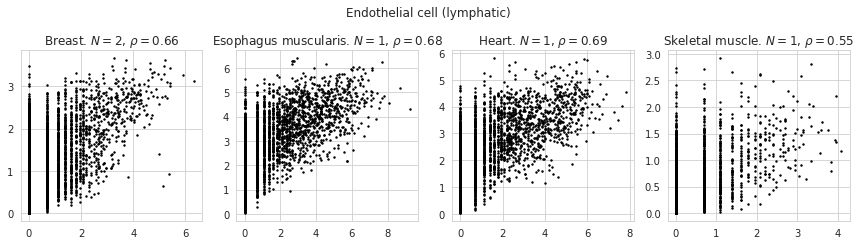

In [42]:
ct = 1

ct_idxs = np.argwhere(d.target['Cell type'].cpu().numpy() == ct).flatten()
tissue_idxs = np.unique(d.target['Tissue'][ct_idxs].cpu().numpy())

nrows = len(tissue_idxs)//3
fig = plt.figure(figsize=(12, 6 + 3.5*(nrows-1)))
plt.suptitle(ct_dict_inv[ct])
for i, t in enumerate(tissue_idxs):
    t_idxs = np.argwhere(d.target['Tissue'].cpu().numpy() == t).flatten()
    idxs = np.intersect1d(t_idxs, ct_idxs)
    
    log_inferred_signatures_ct = np.log1p(inferred_signatures[idxs]).flatten()
    log_real_signatures_ct = np.log1p(real_signatures[idxs]).flatten()
    
    plt.subplot(len(tissue_idxs)//3+1, 4, i+1)
    plt.scatter(log_real_signatures_ct, log_inferred_signatures_ct, s=2, c='black')  # c=inferred_dropouts[idxs]
    score = pearson_correlation(log_real_signatures_ct, log_inferred_signatures_ct)  # r2_score(log_real_signatures_ct, log_inferred_signatures_ct)
    plt.title(r'{}. $N={}$, $\rho = {:.2f}$'.format(tissue_dict_v9_inv[t], len(idxs), score));
fig.tight_layout();

/tmp/ipykernel_2924618/3645364874.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4, 4))


<Figure size 432x288 with 0 Axes>

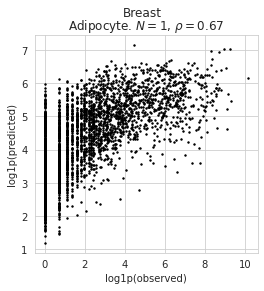

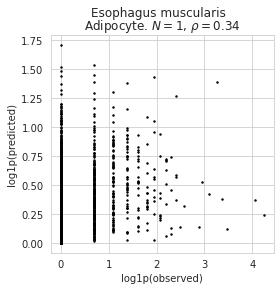

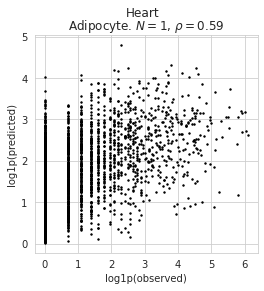

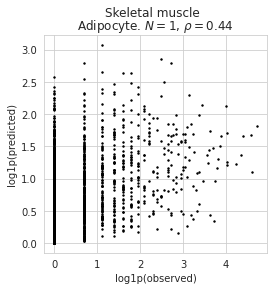

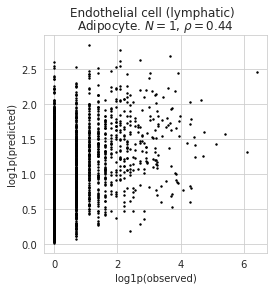

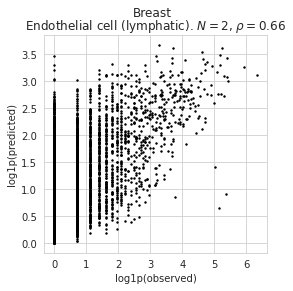

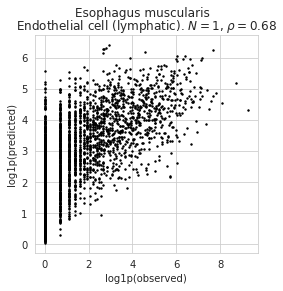

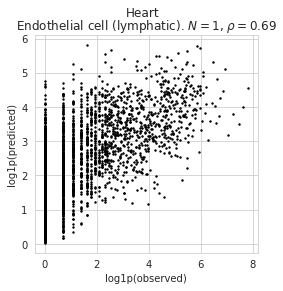

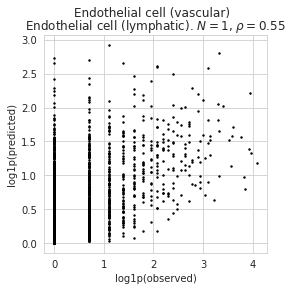

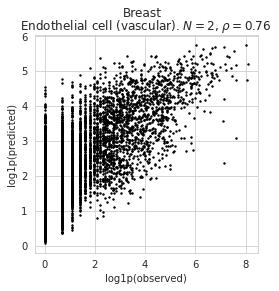

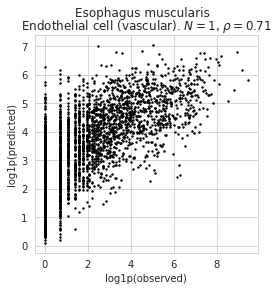

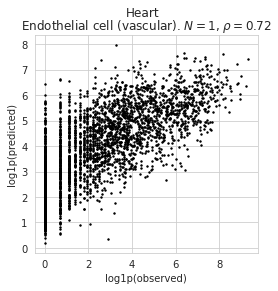

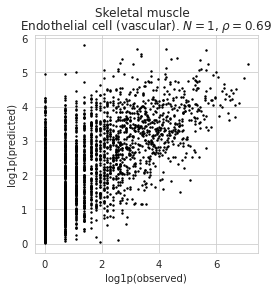

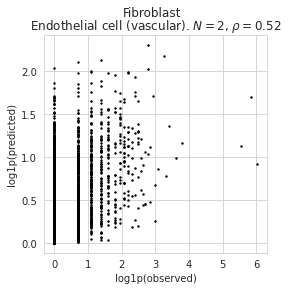

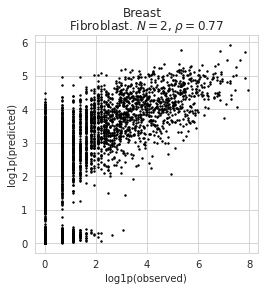

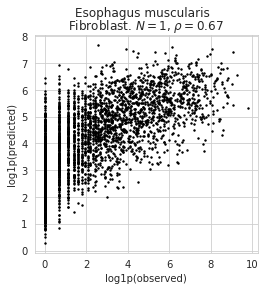

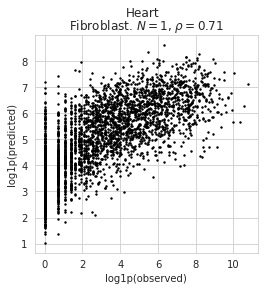

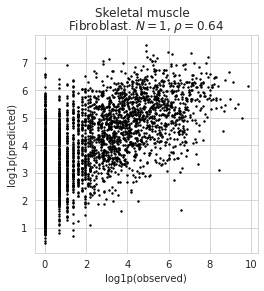

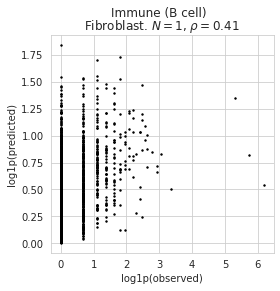

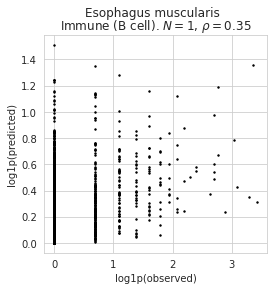

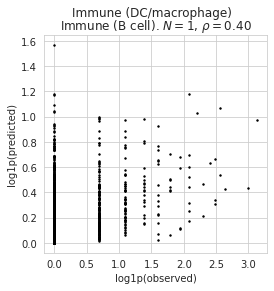

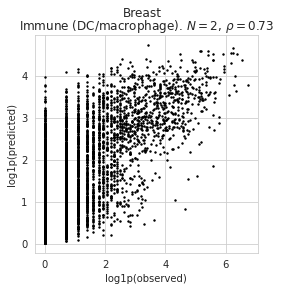

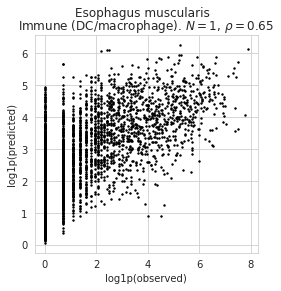

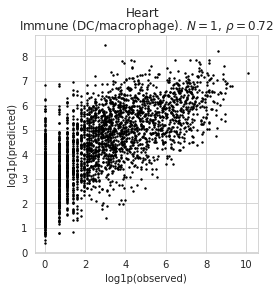

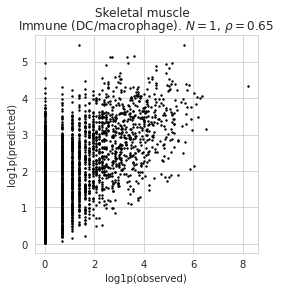

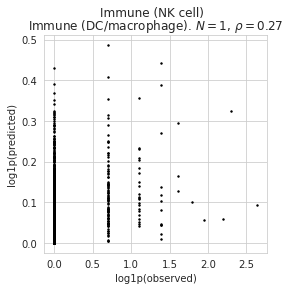

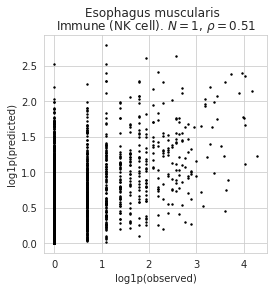

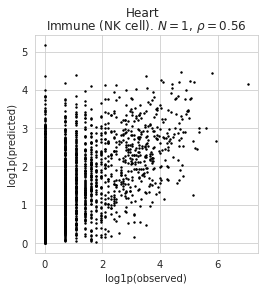

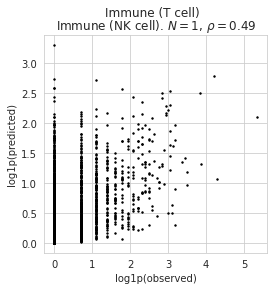

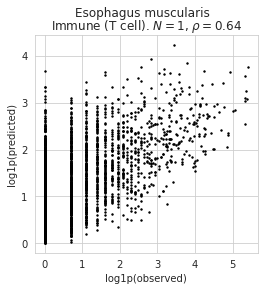

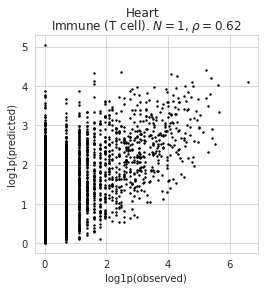

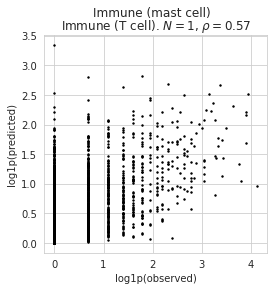

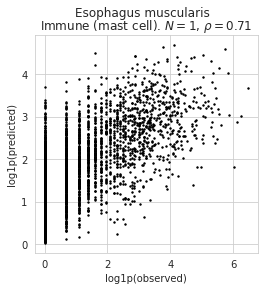

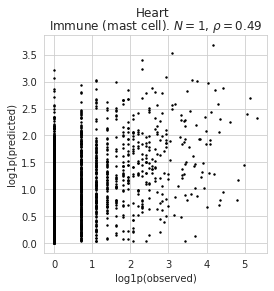

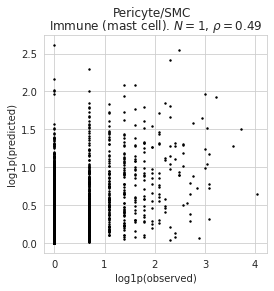

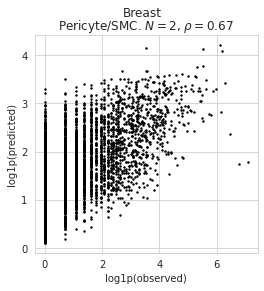

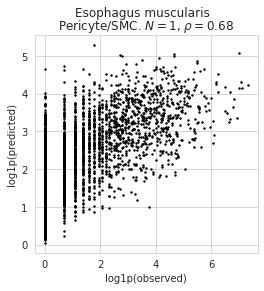

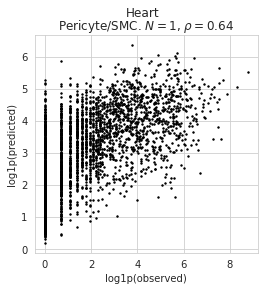

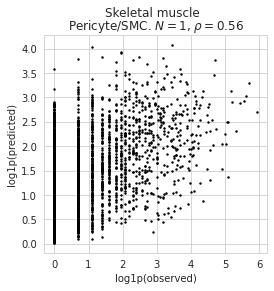

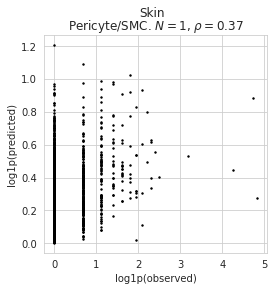

In [51]:
for ct in range(11):
    ct_idxs = np.argwhere(d.target['Cell type'].cpu().numpy() == ct).flatten()
    tissue_idxs = np.unique(d.target['Tissue'][ct_idxs].cpu().numpy())

    nrows = len(tissue_idxs)//3
    plt.suptitle(ct_dict_inv[ct])
    for i, t in enumerate(tissue_idxs):
        t_idxs = np.argwhere(d.target['Tissue'].cpu().numpy() == t).flatten()
        idxs = np.intersect1d(t_idxs, ct_idxs)
        
        if len(idxs) > 0:
            log_inferred_signatures_ct = np.log1p(inferred_signatures[idxs]).flatten()
            log_real_signatures_ct = np.log1p(real_signatures[idxs]).flatten()

            plt.figure(figsize=(4, 4))
            plt.scatter(log_real_signatures_ct, log_inferred_signatures_ct, s=2, c='black')  # c=inferred_dropouts[idxs]
            score = pearson_correlation(log_real_signatures_ct, log_inferred_signatures_ct)  # r2_score(log_real_signatures_ct, log_inferred_signatures_ct)
            plt.title(r'{}. $N={}$, $\rho = {:.2f}$'.format(ct_dict_inv[ct], len(idxs), score))
            plt.xlabel('log1p(observed)');
            plt.ylabel('log1p(predicted)');
            plt.suptitle(tissue_dict_v9_inv[t], fontsize=12)
            plt.savefig('{}/figures/ct_signatures_observed{}/{}_{}.pdf'.format(RESULTS_DIR, use_observed_library, tissue_dict_v9_inv[t], ' '.join(ct_dict_inv[ct].split('/'))), bbox_inches='tight');

/tmp/ipykernel_2924618/752513129.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(img, fraction=0.046, pad=0.04)


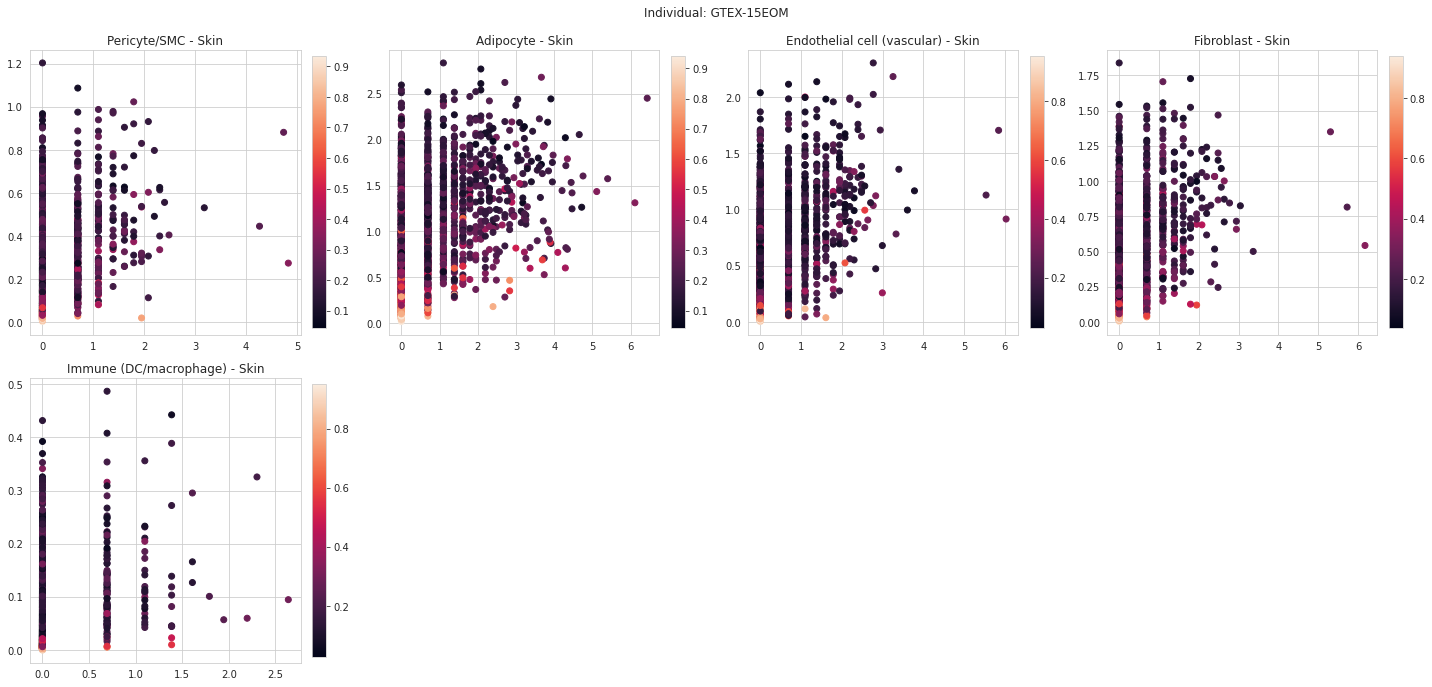

In [52]:
ind = 0

# Predict tissue-specific signatures for each participant
d = val_mixed_dataset[ind]

model.eval()
with torch.no_grad():
    d = d.to(device)
    node_features = encode(d, model)
    
    # Set latents to mean
    (dynamic_node_features_, static_node_features) = node_features
    dynamic_node_features_['Participant ID']['latent'] = dynamic_node_features_['Participant ID']['mu']
    node_features_ = (dynamic_node_features_, static_node_features)
    
    # Compute signatures
    out = decode(d, model, node_features_, use_observed_library=True, use_library_mean=True, n_cells=0)
    x_pred = ZeroInflatedNegativeBinomial(mu=out['px_rate'], theta=out['px_r'], zi_logits=out['px_dropout']).mean
    dropout_probs = torch.exp(out['px_dropout']) / (1 + torch.exp(out['px_dropout']))

x_gt = np.log1p((d.x_target).cpu().numpy())
x_p = np.log1p(x_pred.cpu().numpy())
dropout_p = dropout_probs.cpu().numpy()
target_tissues = [tissue_dict_v9_inv[t] for t in d.target['Tissue'].cpu().numpy()]
target_cts = [ct_dict_inv[c] for c in d.target['Cell type'].cpu().numpy()]
# pearson_correlation_score(x_gt, x_p, sample_corr=True)

# Scatter plot of signatures
nrows = x_gt.shape[0] // 4 + 1
plt.figure(figsize=(20, 5*nrows))

participant = d.target_dynamic['Participant ID'].values[0]
plt.suptitle('Individual: {}'.format(participant))
for i in range(x_gt.shape[0]):
    plt.subplot(nrows, 4, i+1)
    img = plt.scatter(x_gt[i], x_p[i], c=dropout_p[i])
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.ax.get_yaxis().labelpad = 18
    plt.title('{} - {}'.format(target_cts[i], target_tissues[i]))
plt.tight_layout(rect=[0, 0.03, 1, 0.99]);
# plt.savefig('/home/rv340/multitissue_imputation/overleaf/figures/deconvolution/scatter_signatures_{}.pdf'.format(participant), bbox_inches='tight');

#### Select genes for deconvolution

In [57]:
#### Generic signatures 
targets = [] 
preds = [] 
with torch.no_grad(): 
    for i in tqdm(range(len(train_mixed_dataset))): 
        d = train_mixed_dataset[i] 
        
        with torch.no_grad():
            d = d.to(device)
            node_features = encode(d, model)

            # Set latents to mean
            (dynamic_node_features_, static_node_features) = node_features
            dynamic_node_features_['Participant ID']['latent'] = dynamic_node_features_['Participant ID']['mu']
            node_features_ = (dynamic_node_features_, static_node_features)

            # Compute signatures
            out = decode(d, model, node_features_, n_cells=0, use_observed_library=True, use_library_mean=True)
            x_pred = ZeroInflatedNegativeBinomial(mu=out['px_rate'], theta=out['px_r'], zi_logits=out['px_dropout']).mean

        preds.append(x_pred) 
        targets.append(d.x_target) 
preds = torch.cat(preds) 
targets = torch.cat(targets)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.36it/s]


In [58]:
score_fn = r2_score # pearson_correlation_score
gene_scores = score_fn(np.log1p(targets.cpu().numpy()), 
                       np.log1p(preds.cpu().numpy()), sample_corr=False)  

/auto/homes/rv340/HYFA/src/eval_utils.py:28: RuntimeWarning: divide by zero encountered in true_divide
  r_sq = 1 - ss_res / ss_tot


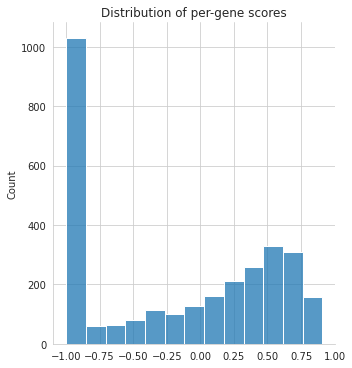

In [59]:
gene_scores = np.copy(gene_scores)
gene_scores[np.isnan(gene_scores)] = 0
sns.displot(np.clip(gene_scores, a_min=-1, a_max=1))
plt.title('Distribution of per-gene scores');

In [60]:
sorted_idxs = np.argsort(gene_scores)[::-1]   # TODO: Use different metric

In [61]:
gene_scores[sorted_idxs[0]]

0.9094626

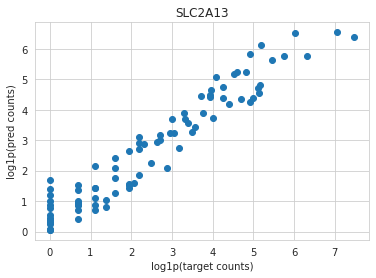

In [62]:
gene_idx = sorted_idxs[0] 
plt.title(adata_v9.var['Symbol'][gene_idx]) 
plt.scatter(np.log1p(targets.cpu().numpy())[:, gene_idx],  
            np.log1p(preds.cpu().numpy())[:, gene_idx]) 
plt.xlabel('log1p(target counts)'); 
plt.ylabel('log1p(pred counts)'); 

#### Perform deconvolution

In [63]:
ind = 4
tidx = 0
d = train_mixed_dataset[ind] # val_mixed_dataset[ind]

n_cells = 1000
use_observed_library = True
inference_mode = 'mean'
generative_mode = 'sample'

# Obtain pseudo-bulk sample
target_tissues = [tissue_dict_v9_inv[t] for t in d.target['Tissue'].cpu().numpy()]
target_cts = [ct_dict_inv[c] for c in d.target['Cell type'].cpu().numpy()]
participant_id = d.target_dynamic['Participant ID'][0]
target_tissue = np.unique(target_tissues)[tidx]
target_tissue_mask = np.array(target_tissues) == target_tissue
target_cts = np.array(target_cts)[target_tissue_mask]
# selected_target_cts = [ct for ct in target_cts if ct not in ['Immune (NK cell)', 'Immune (B cell)', 'Schwann cell']]
selected_target_cts = [ct for ct in target_cts]
target_cts_mask = np.isin(np.array(target_cts), selected_target_cts)

# Convolve
X_convolved, cell_type_proportions, total_cells = convolve(adata_v9, participant_id, target_tissue, selected_target_cts)

In [64]:
d.x_target = d.x_target[target_tissue_mask]
d.target['Tissue'] = d.target['Tissue'][target_tissue_mask]
d.target['Cell type'] = d.target['Cell type'][target_tissue_mask]
d.target['Participant ID'] = d.target['Participant ID'][target_tissue_mask]
d.target_misc['n_cells'] = d.target_misc['n_cells'][target_tissue_mask]

# Predict tissue-specific signatures for each participant
individual_signatures = infer_signatures(d, model, device,
                                         inference_mode=inference_mode,
                                         generative_mode=generative_mode,
                                         use_observed_library=use_observed_library,
                                         use_library_mean=True,
                                         n_cells=n_cells,
                                         preprocess_fn=None)
real_signatures = ((d.x_target / d.target_misc['n_cells'][:, None]).cpu().numpy())[target_cts_mask]
individual_signatures = (individual_signatures / n_cells)[target_cts_mask]

# Generic signatures
dataset_v8 = HypergraphDataset(adata_v8, static=True)

preds = []
for i in tqdm(range(len(dataset_v8))):
    d_v8 = dataset_v8[i]

    # Modify target to match desired cell-type signatures in desired tissue
    d_v8.target = d.target
    d_v8.target_misc = d.target_misc
    d_v8.x_target = d.x_target

    x_pred = infer_signatures(d_v8, model, device,
                              inference_mode=inference_mode,
                              generative_mode=generative_mode,
                              use_observed_library=use_observed_library,
                              use_library_mean=True,
                              n_cells=n_cells,
                              preprocess_fn=None)
    x_pred = (x_pred/n_cells)[target_cts_mask]
    preds.append(x_pred)
    
signatures_per_individual = np.stack(preds, axis=0)
generic_signatures = np.nanmean(signatures_per_individual, axis=0)  # For some reasons some of the predictions return NaN...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [00:07<00:00, 104.54it/s]


In [65]:
real_signatures.sum(axis=-1), individual_signatures.sum(axis=-1), generic_signatures.sum(axis=-1)

(array([219.41669, 151.08824, 394.5    , 176.66667, 142.5    , 155.29999],
       dtype=float32),
 array([172.91699 , 115.745   , 325.666   , 147.11    , 117.378006,
        117.474   ], dtype=float32),
 array([181.49939, 122.76867, 314.53165, 141.70172, 118.28556, 124.53195],
       dtype=float32))

In [75]:
proportions = {} 
gene_idxs = sorted_idxs[:400] # [:1000]  # top_de_gene_idxs# [:200]  # top_de_r2_gene_idxs  # sorted_idxs # [:100] # [:100]  # sorted_idxs[:100]  # top_de_r2_gene_idxs # sorted_idxs[:100]  # np.arange(X_convolved.shape[0])  # top_de_gene_idxs  # top_de_r2_gene_idxs 
# gene_weights = (gene_scores  - gene_scores.min())/(gene_scores.max() - gene_scores.min())
# gene_weights = gene_weights[gene_idxs]
gene_weights = None
X_conv = X_convolved[gene_idxs] 
 
deconvolution_method = LinearRegression
    
# Linear regression with generic signatures 
signatures = generic_signatures[:, gene_idxs] 
reg = deconvolution_method(positive=True, fit_intercept=False).fit(signatures.T, X_conv, sample_weight=gene_weights)  # Ridge(alpha=0.01, positive=True, fit_intercept=False).fit(signatures.T, X_convolved) 
predicted_proportions = reg.coef_ / reg.coef_.sum() 
proportions['w/ predicted generic signatures'] = {ct: v for ct, v in zip(cell_type_proportions.keys(), predicted_proportions)} 

# Linear regression with predicted signatures 
signatures = individual_signatures[:, gene_idxs] 
reg = deconvolution_method(positive=True, fit_intercept=False).fit(signatures.T, X_conv, sample_weight=gene_weights)  # Ridge(alpha=0.01, positive=True, fit_intercept=False).fit(signatures.T, X_convolved) 
predicted_proportions = reg.coef_ / reg.coef_.sum() 
proportions['w/ predicted individual signatures'] = {ct: v for ct, v in zip(cell_type_proportions.keys(), predicted_proportions)}
 
# Linear regression with real signatures 
signatures = real_signatures[:, gene_idxs]   # d.x_target.cpu().numpy()[:, gene_idxs] 
reg = deconvolution_method(positive=True, fit_intercept=False).fit(signatures.T, X_conv)  # Ridge(alpha=0.01, positive=True, fit_intercept=False).fit(signatures.T, X_convolved) 
predicted_proportions = reg.coef_ / reg.coef_.sum() 
proportions['w/ real signatures'] = {ct: v for ct, v in zip(cell_type_proportions.keys(), predicted_proportions)} 

# Ground truth proportions 
proportions['Ground truth'] = cell_type_proportions                                                                              

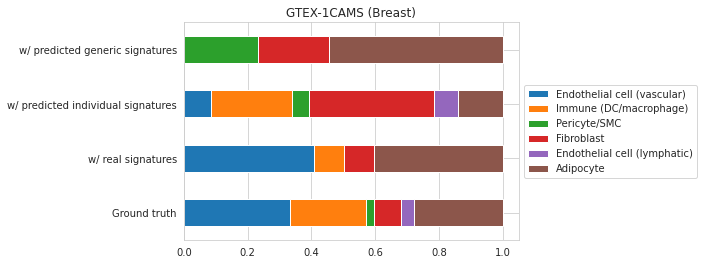

In [76]:
results_df = pd.DataFrame()

# Ground truth
for method, props in proportions.items():
    df = pd.DataFrame()
    df['Cell type'] = props.keys()
    df[method] = props.values()
    df = df.set_index('Cell type').T
    results_df = pd.concat([df, results_df])

results_df.plot(kind='barh', stacked=True)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('{} ({})'.format(participant_id, target_tissue));

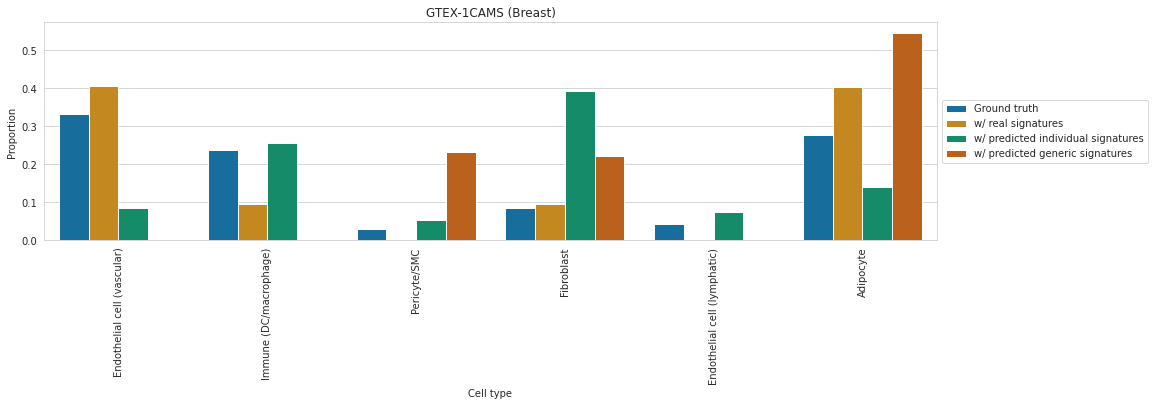

In [77]:
results_df = pd.DataFrame()

# Ground truth
for method, props in proportions.items():
    df = pd.DataFrame()
    df['Cell type'] = props.keys()
    df['Proportion'] = props.values()
    df['Method'] = [method] * len(cell_type_proportions)
    results_df = pd.concat([df, results_df])

plt.figure(figsize=(16, 4))
sns.barplot(x='Cell type', y='Proportion', hue='Method', data=results_df, palette='colorblind')
plt.title('{} ({})'.format(participant_id, target_tissue));
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90);

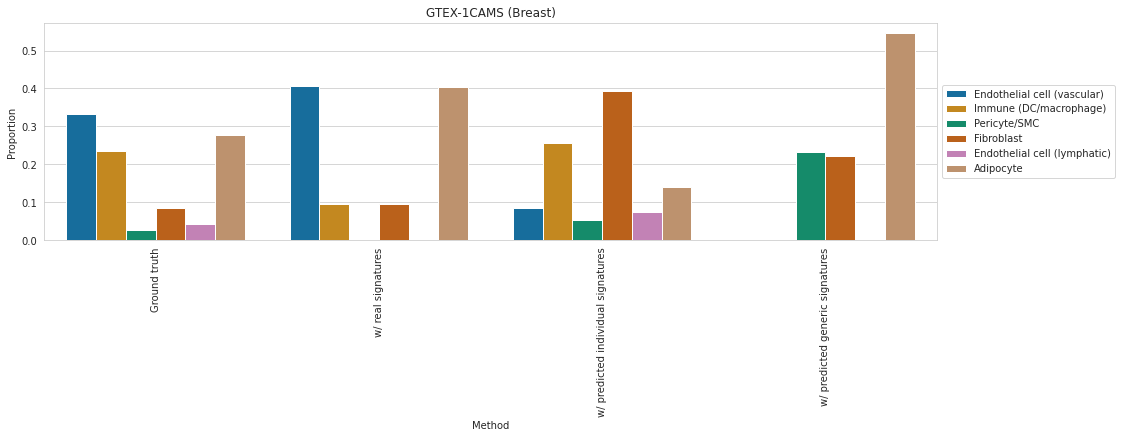

In [78]:
plt.figure(figsize=(16, 4))
sns.barplot(x='Method', y='Proportion', hue='Cell type', data=results_df, palette='colorblind')
plt.title('{} ({})'.format(participant_id, target_tissue));
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90);

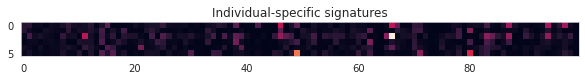

In [91]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log1p(individual_signatures[:, gene_idxs[:100]])) # / np.array(list(cell_type_counts.values()))[:, None])
plt.title('Individual-specific signatures')
plt.gca().grid(False);

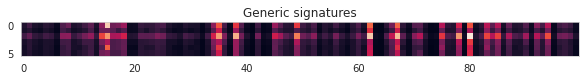

In [92]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log1p(generic_signatures[:, gene_idxs[:100]]))  # /np.array(list(cell_type_counts.values()))[:, None])
plt.title('Generic signatures')
plt.gca().grid(False);

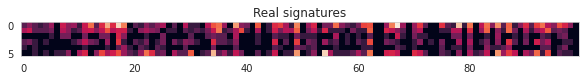

In [93]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log1p(d.x_target.cpu().numpy()[:, gene_idxs[:100]]))
plt.title('Real signatures')
plt.gca().grid(False);

#### Cell-type embeddings

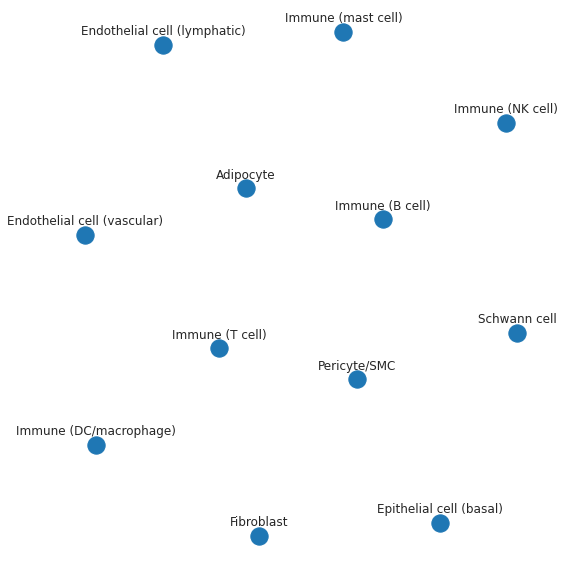

In [105]:
params = model.params['Cell type'].cpu().detach().numpy()

ct_params_2d = TSNE(n_components=2,
                    learning_rate='auto',
                    init='random',
                    random_state=0).fit_transform(params)

plt.figure(figsize=(8, 8))

ax = plt.gca()
x1, x2 = ct_params_2d.T
ax.scatter(x1, x2,
           # c=colors,
           s=300)

for i, t in ct_dict_inv.items():
    x_coord = x1[i]
    y_coord = x2[i]
    txt = t.replace('_', ' ').replace('Brain', '')
        
    ax.annotate(txt, (x_coord, y_coord),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                fontsize=12,
                # fontweight='bold',
                # rotation=45,
                ha='center')
plt.axis('off')
# plt.title('Tissue embeddings from multi-tissue imputation model', fontsize=14)
plt.tight_layout()